In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, LeakyReLU
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#Checking for GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3646039619664212828
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3138361755
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12049720390125203914
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
#Importing the Dataset with TDS
dataset = pd.read_csv('2021_10_31_cleaned_lake_dataset_with_tds.csv', header=0, index_col=0)
dataset = dataset.rename(columns={'actual_conductivity':'cond', 'total_dissolved_solids':'tds', 'do_concentration':'do', 'turbidity':'turb', 'chl-a_concentration':'chl-a', 'temperature':'temp'})
dataset = dataset[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a']]
dataset = dataset.drop(columns=['tds'])
dataset.sort_index()
dataset = dataset['2019-02-20' : '2019-09-12'] #trimming from feb to apr
dataset.tail()

,temp,cond,do,turb,chl-a
datetime,,,,,
2019-04-05 09:00:17,28.91959,76.91243,3.080355,63.40566,49.60603
2019-04-05 09:10:17,28.94431,76.73137,3.062878,72.05052,47.30184
2019-04-05 09:20:17,28.93608,76.69234,2.589782,63.05659,44.22813
2019-04-05 09:30:17,28.94136,76.72667,2.999108,80.66748,45.35073
2019-04-05 09:40:17,28.96102,76.72181,3.165897,68.04305,44.16881


In [4]:
dataset.to_csv("2021_11_03_cleaned_lake_dataset_feb-apr.csv")

ERROR! Session/line number was not unique in database. History logging moved to new session 237


ERROR! Session/line number was not unique in database. History logging moved to new session 231


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AED36C90F0>,
      dtype=object)

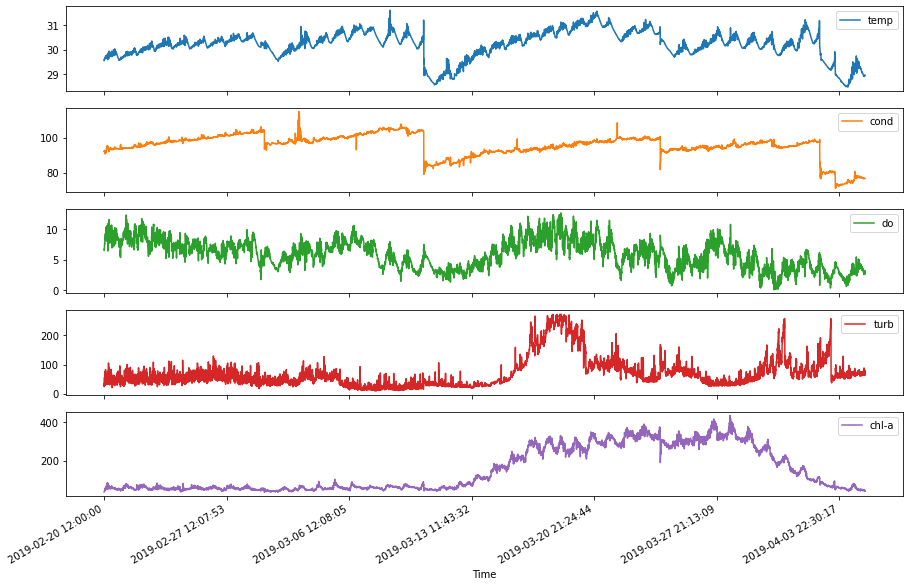

In [15]:
dataset.sort_index()[['temp', 'cond', 'do', 'turb', 'chl-a']].plot(subplots=True, figsize = (15,10), xlabel= 'Time')

Text(0.5, 1.08, 'Pair Plot of Six Water Quality Parameters')

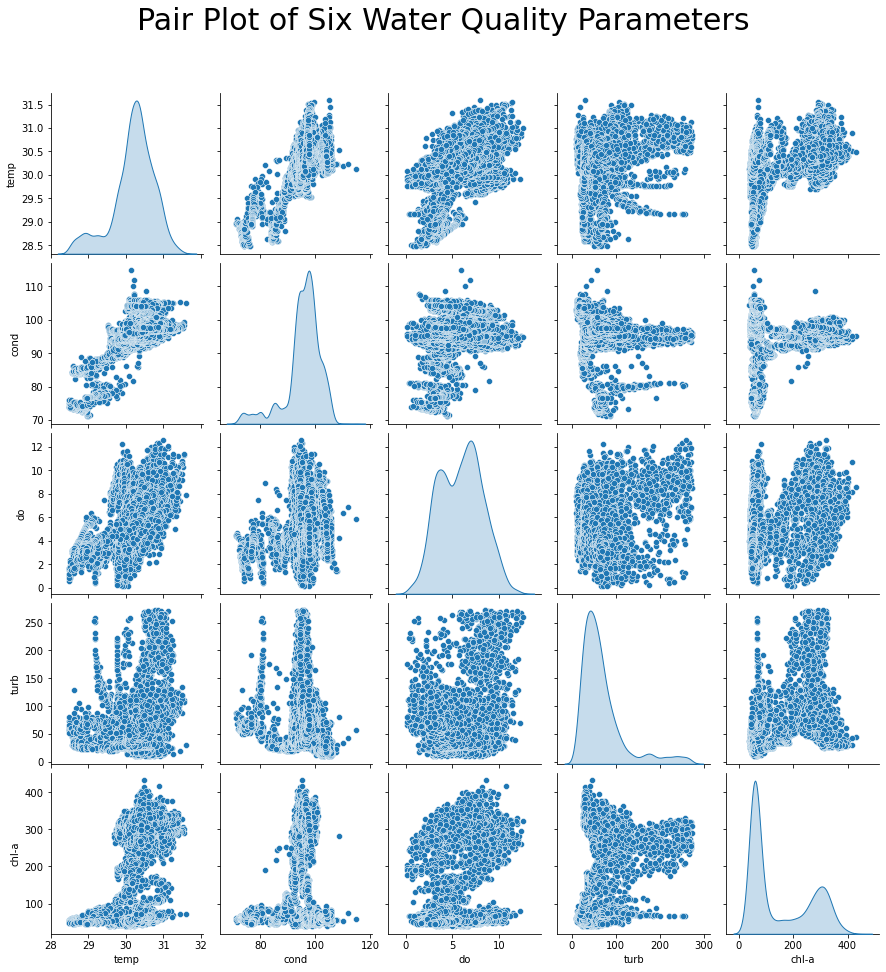

In [17]:
import seaborn as sns
#Pair Plot in SNS
g = sns.pairplot(dataset[['temp', 'cond', 'do', 'turb', 'chl-a']], diag_kind="kde")
g.fig.suptitle("Pair Plot of Six Water Quality Parameters", y=1.08, fontsize = 30) # y= some height>1

In [21]:
df_input = dataset[['temp', 'cond', 'do', 'turb', 'chl-a']]

In [22]:
df_input.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,6212.0,30.203959,0.561186,28.474770,29.962573,30.272155,30.565432,31.59563
cond,6212.0,95.458389,6.483248,71.087590,93.466335,96.658695,99.286892,114.86640
do,6212.0,5.899829,2.289520,0.115000,4.003639,6.015088,7.564055,12.57992
turb,6212.0,68.523069,50.491905,9.632318,36.512010,54.603220,80.075913,272.18700
chl-a,6212.0,151.259812,112.271004,38.279750,57.882942,74.848465,273.295100,432.32650


In [23]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
print(data_scaled)

[[0.34668969 0.48057314 0.51153259 0.0884978  0.00347421]
 [0.35790776 0.48289435 0.5302261  0.05588399 0.00582218]
 [0.35315907 0.47612601 0.52646602 0.14408207 0.00660566]
 ...
 [0.14781503 0.12802427 0.19853972 0.20347865 0.01509562]
 [0.14950687 0.12880843 0.23137796 0.27055378 0.01794452]
 [0.15580641 0.12869742 0.24475863 0.22247073 0.01494508]]


In [26]:
features = data_scaled[:,:-1]
target = data_scaled[:,-1]
print(target)

[0.00347421 0.00582218 0.00660566 ... 0.01509562 0.01794452 0.01494508]


In [28]:
#Trying out timeseries generator
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.34668969, 0.48057314, 0.51153259, 0.0884978 ],
         [0.35790776, 0.48289435, 0.5302261 , 0.05588399]]]),
 array([0.00660566]))

In [29]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)
print(x_train.shape)
print(x_test.shape)

(4969, 4)
(1243, 4)


In [30]:
win_length = 720 #5 days data
batch_size = 32
num_features =4

train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [35]:
model = Sequential()
model.add(LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics= ['mae'] )
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 720, 128)          68096     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 720, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 720, 128)          131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 720, 128)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 720, 128)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

In [37]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

history = model.fit_generator(train_generator, epochs=50, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])

Epoch 1/50
133/133 [==============================] - 200s 2s/step - loss: 0.0060 - mae: 0.0531 - val_loss: 0.3321 - val_mae: 0.5463
Epoch 2/50
133/133 [==============================] - 211s 2s/step - loss: 0.0188 - mae: 0.0833 - val_loss: 0.4097 - val_mae: 0.5866
Epoch 3/50
133/133 [==============================] - 204s 2s/step - loss: 0.0206 - mae: 0.0853 - val_loss: 0.4132 - val_mae: 0.5834


ERROR! Session/line number was not unique in database. History logging moved to new session 234


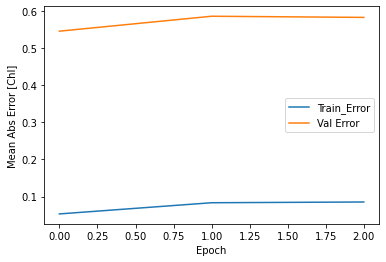

In [56]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Chl]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train_Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label='Val Error')
    plt.legend()
   # plt.ylim([0,20])
    
#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error [$Chl^2$]')
#     plt.plot(hist['epoch'], hist['mse'],
#             label='Train_Error')
#     plt.plot(hist['epoch'], hist['val_mse'],
#             label='Val Error')
#     plt.legend()
    #plt.ylim([0,100])
    
plot_history(history)

In [38]:
model.evaluate_generator(test_generator, verbose=0)

[0.41316479444503784, 0.5834431648254395]

In [40]:
predictions=model.predict_generator(test_generator)
print(predictions.shape)

ERROR! Session/line number was not unique in database. History logging moved to new session 233
(523, 1)


In [41]:
x_test

array([[0.60178284, 0.52796616, 0.6081499 , 0.08772851],
       [0.61531757, 0.52465451, 0.65534644, 0.08908412],
       [0.59012259, 0.53573841, 0.51842433, 0.13800021],
       ...,
       [0.14781503, 0.12802427, 0.19853972, 0.20347865],
       [0.14950687, 0.12880843, 0.23137796, 0.27055378],
       [0.15580641, 0.12869742, 0.24475863, 0.22247073]])

In [42]:
y_test

array([0.84158707, 0.88213911, 0.83869122, ..., 0.01509562, 0.01794452,
       0.01494508])

In [48]:
x_test[:][win_length:]


array([[0.66571073, 0.57819708, 0.3779777 , 0.29457358],
       [0.65562057, 0.5802403 , 0.3759018 , 0.29361793],
       [0.71326493, 0.5863364 , 0.38654013, 0.36283178],
       ...,
       [0.14781503, 0.12802427, 0.19853972, 0.20347865],
       [0.14950687, 0.12880843, 0.23137796, 0.27055378],
       [0.15580641, 0.12869742, 0.24475863, 0.22247073]])

In [49]:
df_pred=pd.concat([pd.DataFrame(x_test[:][win_length:]),  pd.DataFrame(predictions)], axis=1) #concatenating pred with test dataset
df_pred

,0,1,2,3,0
0,0.665711,0.578197,0.377978,0.294574,0.757639
1,0.655621,0.580240,0.375902,0.293618,0.758989
2,0.713265,0.586336,0.386540,0.362832,0.760243
3,0.750649,0.584716,0.423551,0.344469,0.761218
4,0.753686,0.585147,0.407227,0.334693,0.761865
...,...,...,...,...,...
518,0.142531,0.133052,0.237896,0.204808,0.664006
519,0.150452,0.128916,0.236494,0.237734,0.662591
520,0.147815,0.128024,0.198540,0.203479,0.661395
521,0.149507,0.128808,0.231378,0.270554,0.660415


In [50]:
rev_trans = scaler.inverse_transform(df_pred) #reverse transforming
rev_trans

array([[ 30.55236   ,  96.40037   ,   4.826462  ,  86.97399   ,
        336.82479111],
       [ 30.52087   ,  96.48982   ,   4.800586  ,  86.72308   ,
        337.35691295],
       [ 30.70077   ,  96.7567    ,   4.933192  , 104.8955    ,
        337.85112676],
       ...,
       [ 28.93608   ,  76.69234   ,   2.589782  ,  63.05659   ,
        298.90039942],
       [ 28.94136   ,  76.72667   ,   2.999108  ,  80.66748   ,
        298.51401451],
       [ 28.96102   ,  76.72181   ,   3.165897  ,  68.04305   ,
        298.17378159]])

In [53]:
df_final = df_input[predictions.shape[0]*-1:] #getting last rows of the actual dataset
df_final.count()

temp     523
cond     523
do       523
turb     523
chl-a    523
dtype: int64

In [54]:
df_final['chl_pred'] = rev_trans[:,4]
df_final

C:\Users\Pollock\anaconda3\envs\gpu_2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,temp,cond,do,turb,chl-a,chl_pred
datetime,,,,,,
2019-04-01 16:03:09,30.55236,96.40037,4.826462,86.97399,156.44560,336.824791
2019-04-01 16:13:09,30.52087,96.48982,4.800586,86.72308,163.99540,337.356913
2019-04-01 16:23:09,30.70077,96.75670,4.933192,104.89550,156.86370,337.851127
2019-04-01 16:33:09,30.81744,96.68575,5.394529,100.07420,158.29420,338.235186
2019-04-01 16:43:09,30.82692,96.70463,5.191046,97.50761,156.32310,338.490302
...,...,...,...,...,...,...
2019-04-05 09:00:17,28.91959,76.91243,3.080355,63.40566,49.60603,299.929201
2019-04-05 09:10:17,28.94431,76.73137,3.062878,72.05052,47.30184,299.371502
2019-04-05 09:20:17,28.93608,76.69234,2.589782,63.05659,44.22813,298.900399


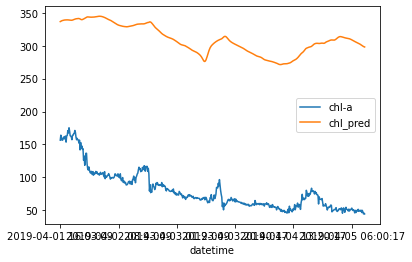

In [55]:
df_final[['chl-a', 'chl_pred']].plot()

In [57]:
#Save Model for later use
model.save('lstm_feb_apr_1')